# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
df[((df.group == 'treatment') & (df.landing_page != 'new_page')) \
   | ((df.group != 'treatment') & (df.landing_page == 'new_page'))].shape

(3893, 5)

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [10]:
# check that the number of rows in the new dataset = 
# number of rows in old dataset - #rows where treatment doesn't equal new page
df2.shape[0] == df.shape[0] - 3893

True

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates(subset=['user_id'], inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
# Make sure the duplicated row is removed
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_control = df2[df2.group == 'control'].converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_treatment = df2[df2.group == 'treatment'].converted.mean()
p_treatment

0.11880806551510564

In [20]:
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:**

From the results above, the conversion probability is essentially the same regardless of the page type, in fact it's slightly higher for the control group with the old page. So there is no sufficient evidence that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Here, there is clearly a directional component associated with our hypotheses.** 

We set our **null hypothesis** to be that the new page has the same effect, or worse than the old page on conversion rates. 

The **alternative hypothesis** would then be that our new page is better than the old page regarding conversion rates.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


**$p_{new}$** and **$p_{old}$** are the population conversion rates for the new and old pages, respectivley. With an $\alpha = 0.05$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2[df2.converted == 1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2[df2.converted == 1].shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2[df2.group == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2[df2.group == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0, 1], n_new, p = [1-p_new, p_new])
new_page_converted.mean()

0.1196132406579038

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0, 1], n_old, p = [1-p_old, p_old])
old_page_converted.mean()

0.12095075512479865

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013375144668948541

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for i in range(10_000):
    new_page_converted_p = np.random.choice([0, 1], n_new, p = [1-p_new, p_new]).mean()
    old_page_converted_p = np.random.choice([0, 1], n_new, p = [1-p_old, p_old]).mean()
    p_diffs.append(new_page_converted_p - old_page_converted_p)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  3.00000000e+00,   1.30000000e+01,   1.71000000e+02,
          7.92000000e+02,   2.33100000e+03,   3.19600000e+03,
          2.35800000e+03,   9.38000000e+02,   1.76000000e+02,
          2.20000000e+01]),
 array([-0.00564311, -0.00462115, -0.0035992 , -0.00257725, -0.0015553 ,
        -0.00053334,  0.00048861,  0.00151056,  0.00253252,  0.00355447,
         0.00457642]),
 <a list of 10 Patch objects>)

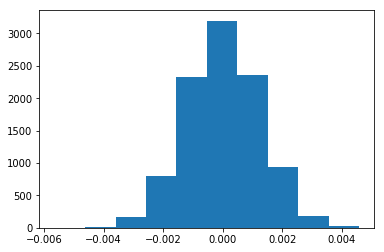

In [30]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
(p_diffs > obs_diff).mean()

0.90539999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**
The value we calculated is the p value. 

As long as this value is larger than our allowed percentage of type I errors, $\alpha$, which is 0.05 in this case, it means we didn't find enough evidence to reject our **null hypothesis** that the new page effect is as good as or worse than the old page effect. Or, in other words, we fail to reject the **null hypothesis**.

As we can see from our *p value* of **0.764**, we fail to reject the **null hypothesis** that the old page is as good as or better than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page == 'old_page'].converted.sum()
convert_new = df2[df2.landing_page == 'new_page'].converted.sum()
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old], value = 0, 
                                      alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

The **z-score** describes how far from the mean of a normal distripution, in both positive and negative directions, our calculated value is.

A **p-value** of **0.91** means that we fail to reject **$H_{0}$** and the conversion rate for the new page is less than or equal to the conversion rate of the old page

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df.group)['treatment']
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
log_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-28 14:52 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**

The **null hypothesis $H_{0}$** here is that a user would not convert if he is shown the new page. And the **alternative hypothesis $H_{1}$** is that a user would convert if shown the new page.

The *p value* associated with **ab_page** is 0.1899, and it's different than the value obtained in part 2 because of the difference in the null and alternative hypotheses, which resulted in performing a two-tailed test as compared to the one-tailed test done in part 2. However, *p value* is still greater than **$\alpha$** and we fail to reject **$H_{0}$** that a user wouldn't convert if shown the new page.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

Since the *p value* we obtained for the **ab_page** shows that it's not statistically significant in relation to whether a user converts or not, it would be a good idea to consider other factors that might affect the conversion as we didn't obtain a relation that we fear to lose by considering other factors.


**The disadvantages:**

- The problem with adding additional terms is that we move away from the area of A/B testing and towards individual recommendations using machine learning. The company's A/B test is only concerned with the new page's effect on conversion.

- Like stated earlier, considering additional terms might affect a statistically significant result that we obtained, but this is not the case here.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
countries_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
df2 = df2.join(countries_df.set_index('user_id'), on='user_id')

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
df2['UK'] = pd.get_dummies(df2.country)['UK']
df2['US'] = pd.get_dummies(df2.country)['US']
df2.drop(columns=['country'], inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [42]:
log_mod_country = sm.Logit(df2.converted, df2[['intercept', 'ab_page', 'UK', 'US']])
results_country = log_mod_country.fit()
results_country.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-28 14:52 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

From the p values obtained for the countries, it seems that country is also not statistically significant with regard to conversion rate. Countries don't affect conversion. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
df2['ab_page_UK'] = df2.ab_page * df2.UK
df2['ab_page_US'] = df2.ab_page * df2.US
log_mod_country_interaction = sm.Logit(df2.converted, df2[['intercept', 'ab_page', 'UK', 'US', 
                                                           'ab_page_UK', 'ab_page_US']])
results_country_interaction = log_mod_country_interaction.fit()
results_country_interaction.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-28 14:52 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

Again, none of the p values obtained for the countries-page interactions is statistically significant with regard to conversion rate. So, we fail to the reject the null hypothesis.

<a id='conclusions'></a>
## Conclusion
From all the tests done, we failed to reject the hypothesis that the old page leads to more or equal number of conversions as the new page.

Further more, regression confirmed this conclusion and showed that country doesn't have an effect on conversion rates.

## Resources
- [Numpy Random Choice function](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

- [What is z-score & p-value](https://stats.stackexchange.com/questions/8472/what-is-the-difference-between-z-scores-and-p-values#:~:text=A%20Z%2Dscore%20describes%20your,as%20extreme%20as%20your%20statistic.)

- [Understanding z-score](https://www.investopedia.com/terms/z/zscore.asp#:~:text=A%20Z-score%20is%20a,identical%20to%20the%20mean%20score.)

- [Solving statsmodel AttributeError: module 'scipy.stats' has no attribute 'chisqprob'](https://stackoverflow.com/a/49838010)

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0